In [1]:
import os
from bs4 import BeautifulSoup
import string
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import load_model
from keras.layers.core import Dense, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import pickle
from keras.optimizers import RMSprop
import numpy as np
from numpy import array
import heapq

2023-02-24 11:11:48.149337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 11:11:48.374070: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-24 11:11:48.374094: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-24 11:11:49.231153: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
documents = []
for file in os.listdir("reuters_sample/"): # original: "reuters_data/"
    if file.endswith('.sgm'): # it is important for GoogleColab
        filename = os.path.join("reuters_sample", file) # original: "reuters_data"
        f = open(filename, 'r', encoding='utf-8', errors='ignore')
        dataFile = f.read().lower()
        
        soup = BeautifulSoup(dataFile, 'html.parser')

        ## get all 'topic'
        # topics = {topic.name for topic in soup.find_all()}
  
        ## iterate all 'topic'
        # for topic in topics:
          
        ## find all element of 'topic'
          # for i in soup.find_all('topic'):
  
        ## if tag has attribute of class
            # if i.has_attr('trade'):
  
# We have selected the following 20 'TOPICS' out of 135:
# that we want to use for our prediction exercise: 1.) "trade" 2.) "earn" 3.) "grain" 4.) "money-fx" 5.) 
# "coffee" 6.) "gold" 7.) "acq" 8.) "wheat" 9.) "veg-oil" 10.) "nat-gas" 11.) "cooper" 12.) "ship" 13.) 
# "dlr" 14.) "crude" 15.) "interest" 16.) "meal-feed" 17.) "alum" 18.) "money-supply" 19.) "cocoa" 20.) "livestock"
        contents = soup.findAll('title')
        
        for content in contents:
            documents.append(content.text)

In [3]:
documents = [i for n, i in enumerate(documents) if i not in documents[:n]]

print('Number of documents: {}'.format(len(documents)))

Number of documents: 6731


In [4]:
data = ""
for d in documents:
    data += d

In [5]:
# improve punctuation
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
print('Number of data: {}'.format(len(data)))
print(data[:100])

Number of data: 302335
bahia cocoa reviewstandard oil <srd> to form financial unittexas commerce bancshares <tcb> files pla


In [6]:
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
data = data.translate(translator)
print(data[:100])

bahia cocoa reviewstandard oil  srd  to form financial unittexas commerce bancshares  tcb  files pla


In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded_data = tokenizer.texts_to_sequences([data])[0]
print(len(encoded_data))
encoded_data[:5]

44856


[3302, 513, 3303, 29, 1457]

In [8]:
unique_words = np.unique(encoded_data)
vocab_size = len(unique_words) + 1  # 0 is reserved for padding so that's why we added 1
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 13007


In [9]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(1, len(encoded_data) - WORD_LENGTH):
    prev_words.append(encoded_data[i:i + WORD_LENGTH])
    next_words.append(encoded_data[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

[513, 3303, 29, 1457, 1]
558


In [10]:
X = prev_words
X = np.array(X)
Y = next_words
Y = np.array(Y)


In [11]:
# one hot encode outputs
Y = to_categorical(Y, num_classes=vocab_size)
# define model
Y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1)) # original: 5
model.add(LSTM(32, return_sequences=True, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

2023-02-24 11:12:45.592749: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-24 11:12:45.592784: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-24 11:12:45.592817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bishal-pc): /proc/driver/nvidia/version does not exist
2023-02-24 11:12:45.593138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 10)             130070    
                                                                 
 lstm (LSTM)                 (None, 1, 32)             5504      
                                                                 
 lstm_1 (LSTM)               (None, 1, 32)             8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 13007)             429231    
                                                                 
Total params: 581,445
Trainable params: 581,445
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
optimizer = RMSprop(lr= 0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

2023-02-24 11:14:07.462090: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2216756996 exceeds 10% of free system memory.


Epoch 1/20
332/333 [============================>.] - ETA: 0s - loss: 8.0873 - accuracy: 0.0352WARNING:tensorflow:Model was constructed with shape (None, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='embedding_input'), name='embedding_input', description="created by layer 'embedding_input'"), but it was called on an input with incompatible shape (None, 5).


2023-02-24 11:14:35.402146: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 116698804 exceeds 10% of free system memory.


333/333 [==============================] - 23s 43ms/step - loss: 8.0870 - accuracy: 0.0352 - val_loss: 8.0298 - val_accuracy: 0.0495
Epoch 2/20
333/333 [==============================] - 12s 37ms/step - loss: 7.6296 - accuracy: 0.0566 - val_loss: 7.9919 - val_accuracy: 0.0709
Epoch 3/20
333/333 [==============================] - 11s 33ms/step - loss: 7.5030 - accuracy: 0.0709 - val_loss: 8.1785 - val_accuracy: 0.0687
Epoch 4/20
333/333 [==============================] - 11s 34ms/step - loss: 7.6025 - accuracy: 0.0813 - val_loss: 8.3384 - val_accuracy: 0.0798
Epoch 5/20
333/333 [==============================] - 11s 34ms/step - loss: 7.4968 - accuracy: 0.0905 - val_loss: 8.7639 - val_accuracy: 0.0807
Epoch 6/20
333/333 [==============================] - 12s 37ms/step - loss: 7.6711 - accuracy: 0.0993 - val_loss: 8.9898 - val_accuracy: 0.0709
Epoch 7/20
333/333 [==============================] - 12s 37ms/step - loss: 7.7935 - accuracy: 0.1096 - val_loss: 9.2260 - val_accuracy: 0.0811
Epo

In [16]:
SEQUENCE_LENGTH = 39

In [17]:
#Saving
model.save('keras_model'+str(SEQUENCE_LENGTH)+'.h5')
pickle.dump(history, open('history'+str(SEQUENCE_LENGTH)+'.p', 'wb'))



#Loading back the saved weights and history

model = load_model('keras_model'+str(SEQUENCE_LENGTH)+'.h5')
history = pickle.load(open('history'+str(SEQUENCE_LENGTH)+'.p', 'rb'))

In [19]:
import matplotlib.pyplot as plt
import matplotlib


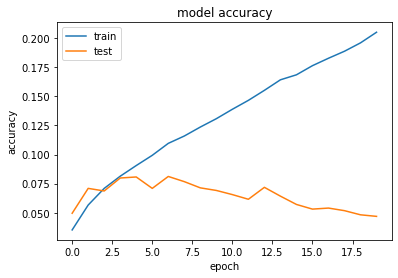

In [21]:
#Evaluation
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc= 'upper left')

plt.savefig("01.Accuracy.png")



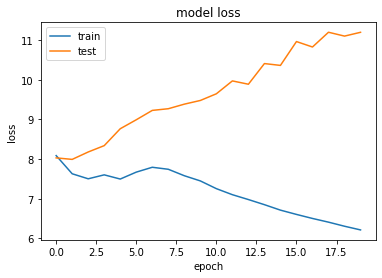

In [22]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc= 'upper left')

plt.savefig("02.Loss.png")

In [27]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(text)))
    chars = sorted(list(set(text)))
    char_indices = dict((c, i) for i, c in enumerate(chars))
    indices_char = dict((i, c) for i, c in enumerate(chars))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1
    return x
#The sequences must be 40 chars long and the tensor is of the shape (1, 40, 57)



#The sample function
#This function allows us to ask our model what are the next probable characters (The heap simplifies the job)
def sample(preds, top_n = 3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)
  
  
  
#Prediction function
def predict_completion(text):
    original_text = text
    generalised = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]

        text = text[1:] + next_char
        completion += next_char

        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion
          
          
          
#This methods wraps everything and allows us to predict multiple completions
def predict_completions(text, n = 3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [30]:
quotes = [
    "GILLETTE CANADA ISSUES 70 MLN STG BOND.",
]


for q in quotes:
    seq = q[:SEQUENCE_LENGTH].lower()
    print (seq)
    print (predict_completions(seq, 5))
    print ()

gillette canada issues 70 mln stg bond.


ValueError: in user code:

    File "/home/dell/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/home/dell/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/dell/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/home/dell/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/home/dell/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/dell/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 39, 39, 10)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 39, 39), dtype=float32)
      • training=False
      • mask=None
